###Hamiltoniano

El sistema se modela con el modelo de Ising de campo aleatorio. El Hamiltoniano del sistema incorpora, además de la interacción de los espines vecinos, un término de la interacción de cada espín con el campo externo (que va a cambiar en el tiempo), y con un campo local aleatorio. 

$$ H = - \sum_{\langle i, j \rangle} J s_i s_j - \sum_{i}(H(t) + h_i)s_i $$

El campo aleatorio se escoge dentro de una distribución Gaussiana:

$$ P(h) =  \frac{1}{\sqrt{2 \pi} R} e^{-h^2/2R^2} $$

Podemos reescribir al Hamiltoniano de la siguiente forma:


$$ H = - \sum_i \, \left[ \sum_{\langle j_i \rangle} J s_i s_j + (H(t) + h_i)s_i\right] $$

donde usamos la notación $\langle j_i \rangle$ para referirnos a los índices de los espines que son primeros vecinos de $s_i$.

Con la suma explícita corriendo sobre el índice $i$, es claro ahora que para un espín fijo $s_i$, la contribución a la energía total del sistema es:

$$ H_i = - s_i \, \left[J \sum_{\langle j_i \rangle} s_j + H(t) + h_i \right] $$
$$     = - s_i T_i $$

###Evolución

Tomamos la temperatura igual a cero, y hacemos que todos los espines apunten hacia abajo. El campo externo se va a incrementar de $-\infty$ a $+\infty$, adiabáticamente, y posteriormente se va a disminuir en sentido contrario.

Originalmente todos los espines apuntan hacia abajo. El campo $H(t)$ es negativo y más grande en valor absoluto que $h_i$, (ésto es $H(t) + h_i < 0$) así que $H_i <0 \, \, \forall i$. 

Empezamos a incrementar el campo externo y buscamos cuándo es más favorable energéticamente que el espín $s_i$ se voltee. Ésto ocurre cuando $T_i$ se vuelve positivo, y por lo tanto $H_i$ se vuelve positivo. Entonces, $s_i$ cambia de signo y hace que $H_i$ sea de nuevo negativo. 

Cuando hacemos el camino inverso, disminuyendo el campo, $s_i$ apunta en un principio hacia arriba y ocurre lo contrario. $T_i$ originalmente es positivo, y cuando se vuelve negativo $s_i$ se voltea para hacer que $H_i$ se mantenga negativo.

# Modelo

In [1]:
using PyPlot

INFO: Loading help data...


In [2]:
type MicroEstado
    σ::Array{Int,2}
    h::Array{Float64,2}
    #Vamos a suponer que todas las configuraciones son cuadradas
    L::Int
end

import Base.show

show(io::IO, m::MicroEstado) = print(io, m.σ)

function edo_inicial(L::Int, R, espin)
    σ = espin*ones(Int, (L,L))

    h = Array(Float64, (L,L))
    for i in 1:L^2
        # Temporal, hay que cambiar la distribución
        h[i] = R*randn()
    end

    MicroEstado(σ, h, L)
end

function edo_aleatorio(L::Int, R)
    σ = rand(0:1, (L,L))*2 - 1

    h = Array(Float64, (L,L))
    for i in 1:L^2
        # Temporal, hay que cambiar la distribución
        h[i] = R*randn()
    end

    MicroEstado(σ, h, L)
end

edo_aleatorio (generic function with 1 method)

In [3]:
function criterio_espin(m::MicroEstado, i::Int, j::Int)
    σ = m.σ ; L = m.L

    σ[mod1(i-1, L),j] + σ[mod1(i+1, L),j] + σ[i,mod1(j-1, L)] + σ[i,mod1(j+1, L)] + m.h[i,j]
end

criterio_espin (generic function with 1 method)

In [4]:
function voltea_espin!(m::MicroEstado, i::Int, j::Int)
    m.σ[i,j] *= -1
end

voltea_espin! (generic function with 1 method)

In [6]:
function max_abajo(m::MicroEstado, valor_min, espin)
    tmp = Array(Float64,(m.L,m.L))
    
    for i = 1:m.L, j = 1:m.L
        if m.σ[i,j] == espin
            tmp[i,j] = -espin*criterio_espin(m,i,j)
        else
            tmp[i,j] = valor_min
        end
    end

    f = findmax(tmp) # Da el máximo y el índice lineal del máximo
    i = mod1(f[2], m.L)
    j = int(ceil(f[2]/m.L))
    
    espin*f[1], i, j
end

max_abajo (generic function with 1 method)

In [8]:
function espines_vecinos_abajo(m::MicroEstado,i::Int,j::Int, espin)
    vecinos = [ (mod1(i-1,m.L),j), (mod1(i+1,m.L),j), (i,mod1(j-1,m.L)), (i,mod1(j+1,m.L)) ]
    vecinos_abajo = (Int,Int)[]

    for k in vecinos
        if m.σ[k...] == espin
            push!(vecinos_abajo, k)
        end
    end

    vecinos_abajo
end

espines_vecinos_abajo (generic function with 1 method)

In [9]:
function avalancha_abajo!(m::MicroEstado, i::Int, j::Int, H::Float64, espin)
    voltea_espin!(m,i,j)
    espines_volteados = [(i,j)]

    candidatos = espines_vecinos_abajo(m,i,j,espin)

    while length(candidatos) > 0
        nuevos_candidatos = (Int,Int)[]

        for k in candidatos
            if m.σ[k...] == espin
                if  -espin*(criterio_espin(m,k...) + H) > 0
                    voltea_espin!(m,k...)
                    push!(espines_volteados,k)
                    nuevos_candidatos = vcat(nuevos_candidatos, espines_vecinos_abajo(m,k...,espin))
                end
            end
        end

        candidatos = nuevos_candidatos
    end

    m, espines_volteados
end

avalancha_abajo (generic function with 1 method)

In [56]:
m = edo_aleatorio(5,1)

5x5 Array{Int64,2}:
  1  1  -1   1   1
 -1  1   1  -1   1
 -1  1  -1   1   1
 -1  1   1  -1   1
 -1  1   1  -1  -1

In [57]:
valor_min = -(maximum(abs(m.h)))-5

max_abajo(m, valor_min, 1)

(-3.101539203490334,2,3)

In [58]:
H = ans[1]

-3.101539203490334

In [59]:
avalancha_abajo!(m, 2,3, H, 1)

(5x5 Array{Int64,2}:
 -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1,[(2,3),(2,2),(1,2),(3,2),(5,2),(1,1),(4,2),(5,3),(1,5),(4,3),(2,5),(1,4),(3,5),(4,5),(3,4)])

In [20]:
magnetizacion(m::MicroEstado) = sum(m.σ)

function magnetizacion_aumenta_H!(m::MicroEstado, H_set, espin)
    valor_min = -(maximum(abs(m.h)))-5
    N = m.L^2
    mag = [magnetizacion(m)]
    
    H,i,j = max_abajo(m, valor_min, espin)
    hs = [H]

    while -espin*(hs[end] - H_set) < 0 && mag[end] != -espin*N
        push!(hs, H)
        m, volteados = avalancha_abajo!(m,i,j,H, espin)
        ΔM = -2espin*length(volteados)
        push!(mag, mag[end] + ΔM)
        H,i,j = max_abajo(m, valor_min, espin)
    end

    mag, hs
end

magnetizacion_aumenta_H (generic function with 1 method)

In [23]:
L = 50
R = 4
N = L^2
m = edo_inicial(L,R,-1)

@time mag1, hs1 = magnetizacion_aumenta_H!(m,15,-1) ;

elapsed time: 0.459258917 seconds (25863984 bytes allocated, 19.27% gc time)


In [24]:
@time mag2, hs2 = magnetizacion_aumenta_H!(m,-15,1) ;

elapsed time: 0.594307545 seconds (25521664 bytes allocated)


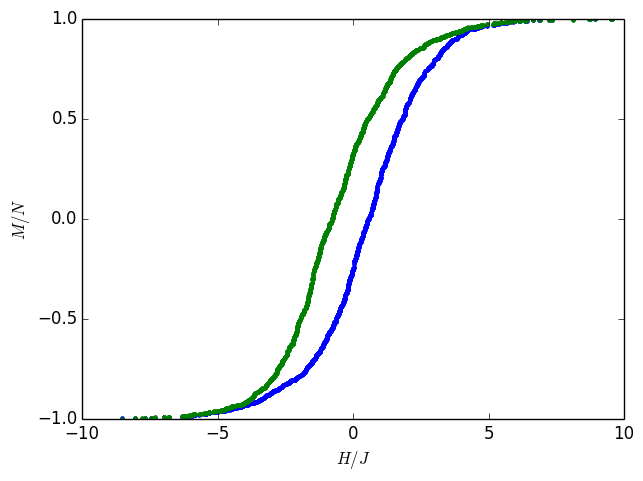

In [25]:
figure(figsize=(7,5))
ylabel(L"M/N")
xlabel(L"H/J") #J=1
plot(hs1,mag1/N, ".")
plot(hs2,mag2/N, ".");